In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
train_dir = 'train'
test_dir = 'test'

In [3]:
train_folders = glob('train/*')

In [4]:
train_folders

['train\\altar',
 'train\\apse',
 'train\\bell_tower',
 'train\\column',
 'train\\dome(inner)',
 'train\\dome(outer)',
 'train\\flying_buttress',
 'train\\gargoyle',
 'train\\stained_glass',
 'train\\vault']

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (128,128)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [8]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = IMG_SIZE,
                                                 batch_size = BATCH_SIZE,
                                                 shuffle = True,
                                                 class_mode = 'categorical')

Found 9935 images belonging to 10 classes.


In [9]:
test_set = test_datagen.flow_from_directory('test',
                                            target_size = IMG_SIZE,
                                            batch_size = BATCH_SIZE,
                                            shuffle=True,
                                            class_mode = 'categorical')

Found 300 images belonging to 10 classes.


In [10]:
class_names = training_set.classes

In [11]:
class_names

array([0, 0, 0, ..., 9, 9, 9])

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [13]:

IMG_SHAPE = IMG_SIZE + (3,)

In [14]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                    include_top=False,
                                                    weights='imagenet')

In [15]:
pretrained_model.trainable = False

In [16]:
pretrained_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [17]:
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10,activation='softmax')
])

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [20]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
    
    def on_train_batch_end(self, batch, logs = None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [21]:
batch_stats_callback = CollectBatchStats()

history = model.fit_generator(
    training_set, epochs=5, validation_data=test_set,
    callbacks=[batch_stats_callback]
    )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
311/311 [==============================] - 253s 812ms/step - loss: 1.6148 - acc: 0.8438 - val_loss: 1.6287 - val_acc: 0.8367
Epoch 2/5
311/311 [==============================] - 53s 172ms/step - loss: 1.5625 - acc: 0.9062 - val_loss: 1.6064 - val_acc: 0.8633
Epoch 3/5
311/311 [==============================] - 55s 177ms/step - loss: 1.5539 - acc: 0.9062 - val_loss: 1.5955 - val_acc: 0.8733
Epoch 4/5
311/311 [==============================] - 56s 179ms/step - loss: 1.6288 - acc: 0.8438 - val_loss: 1.5775 - val_acc: 0.8867
Epoch 5/5
311/311 [==============================] - 58s 185ms/step - loss: 1.5634 - acc: 0.9062 - val_loss: 1.5282 - val_acc: 0.9400


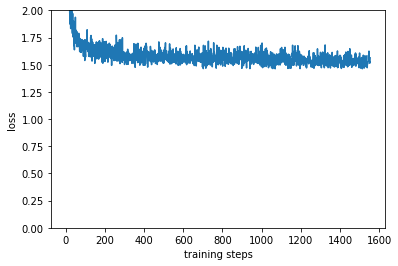

In [22]:
plt.figure()
plt.ylabel('loss')
plt.xlabel('training steps')
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

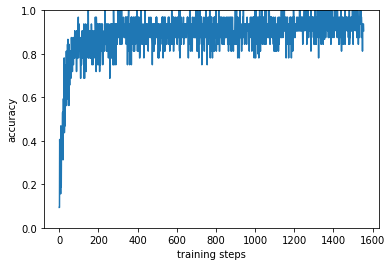

In [23]:
plt.figure()
plt.ylabel('accuracy')
plt.xlabel('training steps')
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [24]:
result = model.evaluate(test_set)

10/10 [==============================] - 0s 37ms/step - loss: 1.5282 - acc: 0.9400


In [25]:
np.argmax(model.predict(test_set), axis = 1)

array([5, 1, 6, 2, 8, 1, 1, 8, 9, 6, 1, 9, 4, 5, 9, 3, 4, 2, 2, 3, 7, 9,
       9, 9, 3, 5, 6, 1, 3, 1, 1, 3, 7, 1, 9, 6, 1, 6, 9, 3, 1, 5, 7, 7,
       1, 8, 4, 1, 7, 9, 4, 9, 6, 0, 4, 6, 0, 1, 8, 9, 9, 4, 9, 1, 7, 9,
       3, 0, 7, 3, 1, 3, 8, 7, 0, 0, 8, 1, 2, 1, 1, 5, 5, 4, 2, 6, 5, 6,
       9, 4, 5, 8, 9, 0, 2, 0, 5, 1, 2, 4, 3, 5, 4, 1, 0, 2, 2, 3, 9, 9,
       5, 2, 9, 0, 0, 1, 4, 9, 3, 0, 0, 1, 8, 6, 9, 0, 3, 6, 1, 7, 3, 0,
       2, 2, 1, 4, 2, 7, 5, 5, 4, 8, 5, 6, 2, 7, 2, 4, 5, 5, 1, 3, 8, 8,
       8, 2, 6, 0, 6, 4, 7, 0, 8, 3, 6, 8, 4, 2, 8, 2, 4, 9, 7, 5, 4, 7,
       4, 2, 4, 1, 5, 1, 8, 9, 5, 8, 5, 0, 0, 9, 9, 0, 5, 6, 1, 3, 3, 4,
       3, 6, 8, 8, 6, 5, 1, 9, 6, 2, 2, 1, 2, 2, 1, 1, 5, 7, 9, 2, 8, 8,
       9, 0, 9, 4, 3, 8, 2, 1, 2, 5, 7, 9, 9, 0, 6, 7, 0, 9, 8, 4, 5, 7,
       7, 3, 7, 4, 3, 6, 7, 5, 4, 7, 0, 4, 9, 1, 0, 3, 5, 7, 2, 3, 0, 3,
       1, 7, 2, 0, 8, 2, 7, 5, 5, 4, 7, 8, 9, 7, 4, 0, 8, 0, 8, 6, 9, 4,
       6, 8, 7, 5, 7, 3, 4, 3, 0, 2, 6, 1, 7, 2], d

In [26]:
tf.keras.models.save_model(model, 'my_model.hdf5')